In [3]:
import sys
from pathlib import Path

project_root = Path.cwd().parent
sys.path.append(str(project_root))

In [4]:
from pathlib import Path

PROJECT_ROOT = Path("..").resolve()   # if notebook is in notebooks/
ARTIFACTS_DIR = PROJECT_ROOT / "artifacts"

(ARTIFACTS_DIR / "models").mkdir(parents=True, exist_ok=True)
(ARTIFACTS_DIR / "metrics").mkdir(parents=True, exist_ok=True)
(ARTIFACTS_DIR / "figures").mkdir(parents=True, exist_ok=True)


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings as wr
wr.filterwarnings('ignore')

In [6]:
sns.set_theme(
    style="darkgrid",   # soft gray background
    context="notebook"  # good sizing for EDA
)

In [7]:
df = pd.read_csv('../data/cs-training.csv')
df.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [8]:
df = df.drop(columns = ['Unnamed: 0'])

In [9]:
X = df.drop(columns = ['SeriousDlqin2yrs'])
y = df['SeriousDlqin2yrs']

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    X,
    y,
    test_size = .2,
    stratify = y,
    random_state = 42
)

In [11]:
X_train_log = X_train.copy()
X_valid_log = X_valid.copy()

skew_cols = [
    "MonthlyIncome",
    "DebtRatio",
    "RevolvingUtilizationOfUnsecuredLines"
]

for col in skew_cols:
    X_train_log[col] = np.log1p(X_train_log[col])
    X_valid_log[col] = np.log1p(X_valid_log[col])

In [12]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy = 'median')
X_train_imp = imputer.fit_transform(X_train_log)
X_valid_imp = imputer.transform(X_valid_log)

In [15]:
n_pos = (y_train == 1).sum()
n_neg = (y_train == 0).sum()
scale_pos_weight = n_neg / n_pos
scale_pos_weight

np.float64(13.960728088766986)

In [16]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    n_estimators=4000,
    learning_rate=0.02,
    max_depth=4,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight,
)

xgb.fit(
    X_train_imp, y_train,              # or X_train_log_imp
    eval_set=[(X_valid_imp, y_valid)],  # or X_valid_log_imp
    verbose=200,
)

[0]	validation_0-auc:0.81243
[200]	validation_0-auc:0.86690
[400]	validation_0-auc:0.86945
[600]	validation_0-auc:0.86970
[800]	validation_0-auc:0.86941
[1000]	validation_0-auc:0.86892
[1200]	validation_0-auc:0.86825
[1400]	validation_0-auc:0.86763
[1600]	validation_0-auc:0.86690
[1800]	validation_0-auc:0.86627
[2000]	validation_0-auc:0.86545
[2200]	validation_0-auc:0.86485
[2400]	validation_0-auc:0.86416
[2600]	validation_0-auc:0.86350
[2800]	validation_0-auc:0.86289
[3000]	validation_0-auc:0.86241
[3200]	validation_0-auc:0.86180
[3400]	validation_0-auc:0.86119
[3600]	validation_0-auc:0.86068
[3800]	validation_0-auc:0.86018
[3999]	validation_0-auc:0.85961


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=4000, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

In [20]:
from sklearn.metrics import roc_auc_score

train_pred = xgb.predict_proba(X_train_imp)[:,1]
valid_pred = xgb.predict_proba(X_valid_imp)[:,1]

auc_train = roc_auc_score(y_train, train_pred)
print('AUC (train): ', auc_train)
auc_valid = roc_auc_score(y_valid, valid_pred)
print('AUC (validation): ', auc_valid)

AUC (train):  0.9184544659428573
AUC (validation):  0.8596082129022862


In [21]:
xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    n_estimators=4000,
    learning_rate=0.02,
    max_depth=3,
    min_child_weight=5,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_lambda=2.0,
    random_state=42,
    gamma = .1,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight,
)

xgb.fit(
    X_train_imp, y_train,              # or X_train_log_imp
    eval_set=[(X_valid_imp, y_valid)],  # or X_valid_log_imp
    verbose=200,
)

[0]	validation_0-auc:0.77885
[200]	validation_0-auc:0.86471
[400]	validation_0-auc:0.86840
[600]	validation_0-auc:0.86928
[800]	validation_0-auc:0.86949
[1000]	validation_0-auc:0.86938
[1200]	validation_0-auc:0.86913
[1400]	validation_0-auc:0.86899
[1600]	validation_0-auc:0.86882
[1800]	validation_0-auc:0.86865
[2000]	validation_0-auc:0.86840
[2200]	validation_0-auc:0.86827
[2400]	validation_0-auc:0.86799
[2600]	validation_0-auc:0.86781
[2800]	validation_0-auc:0.86759
[3000]	validation_0-auc:0.86738
[3200]	validation_0-auc:0.86708
[3400]	validation_0-auc:0.86671
[3600]	validation_0-auc:0.86646
[3800]	validation_0-auc:0.86606
[3999]	validation_0-auc:0.86570


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=4000, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

In [22]:
train_pred = xgb.predict_proba(X_train_imp)[:,1]
valid_pred = xgb.predict_proba(X_valid_imp)[:,1]

auc_train = roc_auc_score(y_train, train_pred)
print('AUC (train): ', auc_train)
auc_valid = roc_auc_score(y_valid, valid_pred)
print('AUC (validation): ', auc_valid)

AUC (train):  0.8929295097462366
AUC (validation):  0.86570147234165


In [29]:
xgb_curve = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    n_estimators=4000,
    learning_rate=0.02,
    max_depth=3,
    min_child_weight=5,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_lambda=2.0,
    reg_alpha=0.5,
    gamma=0.1,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight,
)

xgb_curve.fit(
    X_train_imp, y_train,
    eval_set=[(X_train_imp, y_train), (X_valid_imp, y_valid)],
    verbose=200,
)

[0]	validation_0-auc:0.77603	validation_1-auc:0.77885
[200]	validation_0-auc:0.86288	validation_1-auc:0.86472
[400]	validation_0-auc:0.86840	validation_1-auc:0.86845
[600]	validation_0-auc:0.87126	validation_1-auc:0.86931
[800]	validation_0-auc:0.87353	validation_1-auc:0.86943
[1000]	validation_0-auc:0.87539	validation_1-auc:0.86935
[1200]	validation_0-auc:0.87710	validation_1-auc:0.86910
[1400]	validation_0-auc:0.87865	validation_1-auc:0.86898
[1600]	validation_0-auc:0.88012	validation_1-auc:0.86880
[1800]	validation_0-auc:0.88149	validation_1-auc:0.86865
[2000]	validation_0-auc:0.88277	validation_1-auc:0.86839
[2200]	validation_0-auc:0.88396	validation_1-auc:0.86824
[2400]	validation_0-auc:0.88510	validation_1-auc:0.86804
[2600]	validation_0-auc:0.88626	validation_1-auc:0.86791
[2800]	validation_0-auc:0.88735	validation_1-auc:0.86775
[3000]	validation_0-auc:0.88835	validation_1-auc:0.86746
[3200]	validation_0-auc:0.88935	validation_1-auc:0.86716
[3400]	validation_0-auc:0.89025	valida

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=4000, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

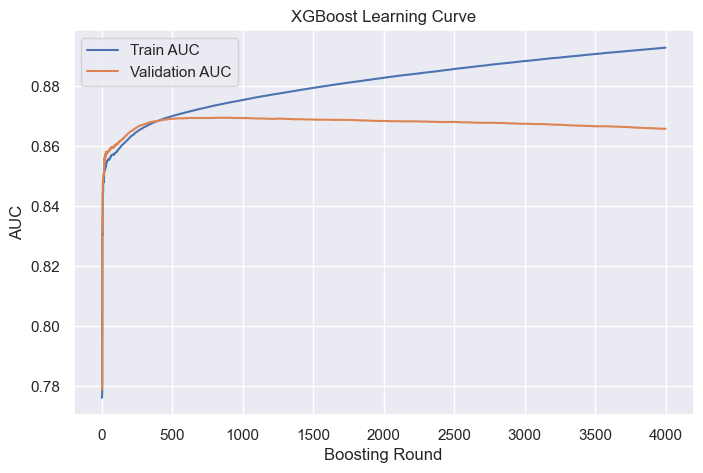

In [31]:
import matplotlib.pyplot as plt

evals = xgb_curve.evals_result()

train_auc = evals["validation_0"]["auc"]
valid_auc = evals["validation_1"]["auc"]

plt.figure(figsize=(8,5))
plt.plot(train_auc, label="Train AUC")
plt.plot(valid_auc, label="Validation AUC")
plt.xlabel("Boosting Round")
plt.ylabel("AUC")
plt.title("XGBoost Learning Curve")
plt.legend()
plt.show()


In [32]:
best_iter = int(np.argmax(valid_auc)) + 1
best_iter

857

In [16]:
from xgboost import XGBClassifier

base = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    learning_rate=0.02,
    n_estimators=1200,   # allow headroom
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight,
)

param_dist = {
    "max_depth": [2, 3, 4],
    "min_child_weight": [5, 10, 20],
    "subsample": [0.6, 0.7, 0.8],
    "colsample_bytree": [0.6, 0.7, 0.8],
    "reg_lambda": [1.0, 2.0, 5.0],
    "reg_alpha": [0.0, 0.5, 1.0],
    "gamma": [0.0, 0.1, 0.2],
}

In [17]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    estimator=base,
    param_distributions=param_dist,
    n_iter=40,              # 30–60 is a good range
    scoring="roc_auc",
    cv=cv,
    verbose=2,
    random_state=42,
    n_jobs=-1,
)

search.fit(X_train_imp, y_train)  # or X_train_imp if you're tuning baseline features


Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV] END colsample_bytree=0.7, gamma=0.0, max_depth=2, min_child_weight=10, reg_alpha=0.0, reg_lambda=5.0, subsample=0.8; total time=   3.3s
[CV] END colsample_bytree=0.7, gamma=0.0, max_depth=2, min_child_weight=10, reg_alpha=0.0, reg_lambda=5.0, subsample=0.8; total time=   3.4s
[CV] END colsample_bytree=0.7, gamma=0.0, max_depth=2, min_child_weight=10, reg_alpha=0.0, reg_lambda=5.0, subsample=0.8; total time=   3.5s
[CV] END colsample_bytree=0.7, gamma=0.2, max_depth=3, min_child_weight=5, reg_alpha=1.0, reg_lambda=1.0, subsample=0.8; total time=   4.0s
[CV] END colsample_bytree=0.7, gamma=0.2, max_depth=3, min_child_weight=5, reg_alpha=1.0, reg_lambda=1.0, subsample=0.8; total time=   4.1s
[CV] END colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=20, reg_alpha=0.5, reg_lambda=1.0, subsample=0.7; total time=   4.3s
[CV] END colsample_bytree=0.7, gamma=0.2, max_depth=3, min_child_weight=5, reg_alpha=1.0, reg_

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='auc',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importa...
                                           multi_strategy=None,
                                           n_estimators=1200, n_jobs=-1,
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8],
                                        'gamma': [0.0, 0.1, 0.2],
                                        'max_depth': [2, 3, 4],
                                        'min_child_weight': [5, 10, 20],
                                        'reg_alpha': [0.0, 0.5, 1.0],
                                        'reg_lambda': [1.0, 2.0, 5.0],
                                        'subsample': [0.6, 0.7, 0.8]},
                   random_state=42, scoring='roc_auc', verbose=2)

In [36]:
res = pd.DataFrame(search.cv_results_)
res.sort_values("mean_test_score", ascending=False)[
    ["mean_test_score", "std_test_score", "params"]
].head(10)


,mean_test_score,std_test_score,params
29,0.864718,0.004400,"{'subsample': 0.8, 'reg_lambda': 2.0, 'reg_alp..."
1,0.864657,0.004324,"{'subsample': 0.8, 'reg_lambda': 1.0, 'reg_alp..."
0,0.864598,0.004505,"{'subsample': 0.7, 'reg_lambda': 1.0, 'reg_alp..."
34,0.864556,0.004416,"{'subsample': 0.6, 'reg_lambda': 5.0, 'reg_alp..."
24,0.864555,0.004441,"{'subsample': 0.6, 'reg_lambda': 2.0, 'reg_alp..."
14,0.864506,0.004310,"{'subsample': 0.7, 'reg_lambda': 1.0, 'reg_alp..."
23,0.864506,0.004480,"{'subsample': 0.6, 'reg_lambda': 2.0, 'reg_alp..."
17,0.864484,0.004412,"{'subsample': 0.6, 'reg_lambda': 1.0, 'reg_alp..."
12,0.864465,0.004337,"{'subsample': 0.7, 'reg_lambda': 5.0, 'reg_alp..."
35,0.864431,0.004358,"{'subsample': 0.6, 'reg_lambda': 2.0, 'reg_alp..."


In [18]:
best_params = search.best_params_
print(best_params)

{'subsample': 0.8, 'reg_lambda': 2.0, 'reg_alpha': 0.0, 'min_child_weight': 20, 'max_depth': 3, 'gamma': 0.1, 'colsample_bytree': 0.6}


In [20]:
best_params = search.best_params_

xgb_refit = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    learning_rate=0.02,
    n_estimators=4000,          # headroom
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight,
    **best_params
)

xgb_refit.fit(
    X_train_imp, y_train,
    eval_set=[(X_train_imp, y_train), (X_valid_imp, y_valid)],
    verbose=200
)

evals = xgb_refit.evals_result()
train_auc_curve = evals["validation_0"]["auc"]
valid_auc_curve = evals["validation_1"]["auc"]

best_iter = int(np.argmax(valid_auc_curve)) + 1
best_valid_auc = float(np.max(valid_auc_curve))
best_iter, best_valid_auc

[0]	validation_0-auc:0.77601	validation_1-auc:0.77871
[200]	validation_0-auc:0.86262	validation_1-auc:0.86415
[400]	validation_0-auc:0.86807	validation_1-auc:0.86841
[600]	validation_0-auc:0.87082	validation_1-auc:0.86944
[800]	validation_0-auc:0.87292	validation_1-auc:0.86949
[1000]	validation_0-auc:0.87470	validation_1-auc:0.86950
[1200]	validation_0-auc:0.87627	validation_1-auc:0.86932
[1400]	validation_0-auc:0.87777	validation_1-auc:0.86922
[1600]	validation_0-auc:0.87920	validation_1-auc:0.86910
[1800]	validation_0-auc:0.88048	validation_1-auc:0.86905
[2000]	validation_0-auc:0.88170	validation_1-auc:0.86873
[2200]	validation_0-auc:0.88284	validation_1-auc:0.86845
[2400]	validation_0-auc:0.88392	validation_1-auc:0.86827
[2600]	validation_0-auc:0.88506	validation_1-auc:0.86799
[2800]	validation_0-auc:0.88604	validation_1-auc:0.86770
[3000]	validation_0-auc:0.88696	validation_1-auc:0.86742
[3200]	validation_0-auc:0.88785	validation_1-auc:0.86722
[3400]	validation_0-auc:0.88871	valida

(791, 0.8695314045659205)

In [22]:
from sklearn.metrics import roc_auc_score

xgb_final = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    learning_rate=0.02,
    n_estimators=best_iter,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight,
    **best_params
)

xgb_final.fit(X_train_imp, y_train)

valid_pred = xgb_final.predict_proba(X_valid_imp)[:, 1]
auc_final = roc_auc_score(y_valid, valid_pred)
auc_final

np.float64(0.8695314045659204)

In [41]:
xgb_curve = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    learning_rate=0.02,
    n_estimators=4000,   # headroom for curve
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight,

    # tuned params
    max_depth=3,
    min_child_weight=20,
    subsample=0.8,
    colsample_bytree=0.6,
    gamma=0.1,
    reg_lambda=2.0,
    reg_alpha=0.0,
)

xgb_curve.fit(
    X_train_imp, y_train,
    eval_set=[(X_train_imp, y_train), (X_valid_imp, y_valid)],
    verbose=False
)

evals = xgb_curve.evals_result()
train_auc = evals["validation_0"]["auc"]
valid_auc = evals["validation_1"]["auc"]


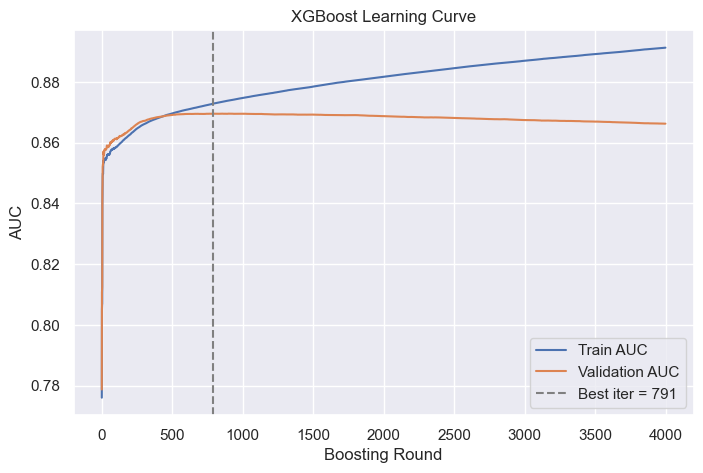

In [42]:
best_iter = int(np.argmax(valid_auc)) + 1
best_auc = float(np.max(valid_auc))
best_iter, best_auc

plt.figure(figsize=(8,5))
plt.plot(train_auc, label="Train AUC")
plt.plot(valid_auc, label="Validation AUC")
plt.axvline(best_iter, linestyle="--", color="gray", label=f"Best iter = {best_iter}")
plt.xlabel("Boosting Round")
plt.ylabel("AUC")
plt.title("XGBoost Learning Curve")
plt.legend()
plt.show()

In [43]:
fi = pd.Series(
    xgb_final.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

fi.head(20)

NumberOfTimes90DaysLate                 0.249724
RevolvingUtilizationOfUnsecuredLines    0.243883
NumberOfTime30-59DaysPastDueNotWorse    0.226098
NumberOfTime60-89DaysPastDueNotWorse    0.150068
NumberRealEstateLoansOrLines            0.036265
age                                     0.032920
NumberOfOpenCreditLinesAndLoans         0.020180
DebtRatio                               0.015340
MonthlyIncome                           0.015231
NumberOfDependents                      0.010291
dtype: float32

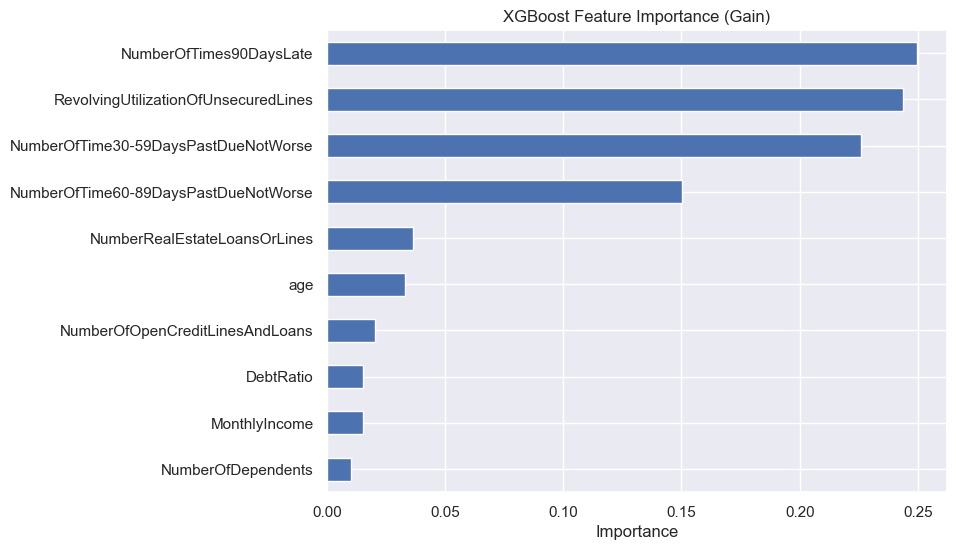

In [44]:
fi.head(20).sort_values().plot(kind="barh", figsize=(8,6))
plt.title("XGBoost Feature Importance (Gain)")
plt.xlabel("Importance")
plt.show()


In [45]:
from sklearn.metrics import precision_score, recall_score

rows = []

for pct in [0.01, 0.02, 0.05, 0.10]:
    threshold = np.percentile(valid_pred, 100 * (1 - pct))
    y_flag = (valid_pred >= threshold).astype(int)

    precision = precision_score(y_valid, y_flag)
    recall = recall_score(y_valid, y_flag)

    rows.append({
        "top_pct_flagged": pct,
        "threshold": threshold,
        "precision": precision,
        "recall": recall,
    })

xgb_metrics = pd.DataFrame(rows)
xgb_metrics

,top_pct_flagged,threshold,precision,recall
0,0.01,0.955691,0.646667,0.096758
1,0.02,0.936670,0.618333,0.185037
2,0.05,0.867404,0.496000,0.371072
3,0.10,0.733694,0.373333,0.558603


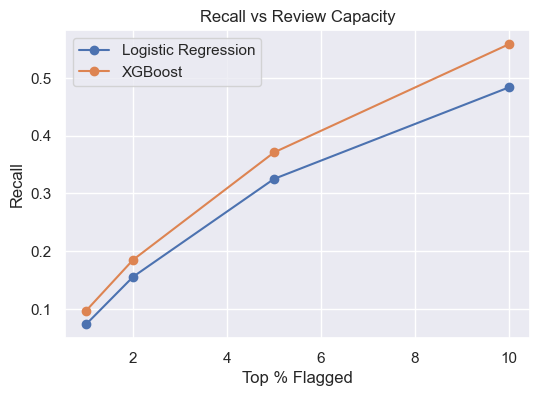

In [46]:
import matplotlib.pyplot as plt

pct = [1, 2, 5, 10]

lr_recall = [0.0733, 0.1556, 0.3252, 0.4838]
xgb_recall = [0.0968, 0.1850, 0.3711, 0.5586]

plt.figure(figsize=(6,4))
plt.plot(pct, lr_recall, marker="o", label="Logistic Regression")
plt.plot(pct, xgb_recall, marker="o", label="XGBoost")
plt.xlabel("Top % Flagged")
plt.ylabel("Recall")
plt.title("Recall vs Review Capacity")
plt.legend()
plt.show()


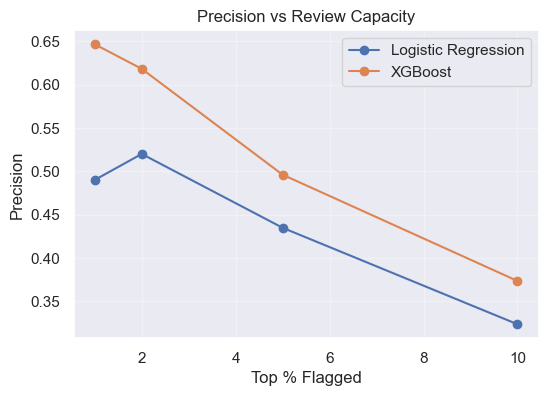

In [47]:
import matplotlib.pyplot as plt

pct = [1, 2, 5, 10]

# from your tables
lr_precision = [0.49, 0.52, 0.4347, 0.3233]
xgb_precision = [0.6467, 0.6183, 0.4960, 0.3733]

plt.figure(figsize=(6,4))
plt.plot(pct, lr_precision, marker="o", label="Logistic Regression")
plt.plot(pct, xgb_precision, marker="o", label="XGBoost")
plt.xlabel("Top % Flagged")
plt.ylabel("Precision")
plt.title("Precision vs Review Capacity")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [50]:
valid_pred = xgb_final.predict_proba(X_valid_imp)[:, 1]

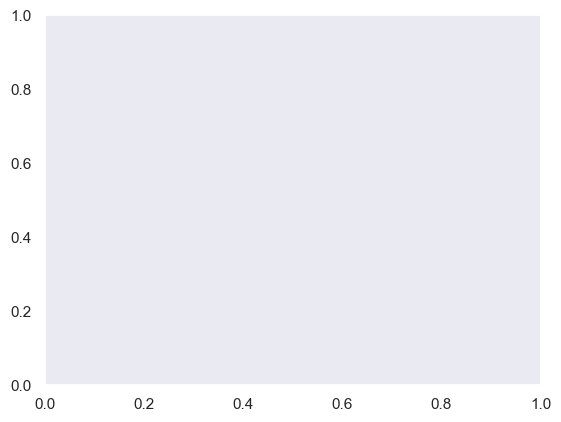

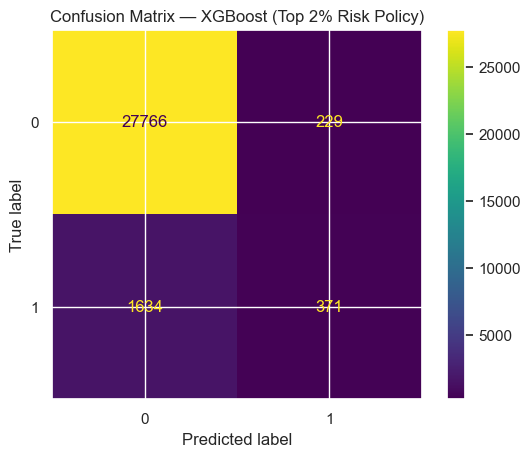

In [64]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Top 2% threshold
threshold_2pct = np.percentile(valid_pred, 98)
y_flag_2pct = (valid_pred >= threshold_2pct).astype(int)

cm_2pct = confusion_matrix(y_valid, y_flag_2pct)
plt.grid(False)          # remove grid

ConfusionMatrixDisplay(cm_2pct).plot()
plt.title("Confusion Matrix — XGBoost (Top 2% Risk Policy)")
plt.savefig(ARTIFACTS_DIR / "figures" / "cm_xgb_top2pct.png", dpi=150, bbox_inches="tight")

plt.show()

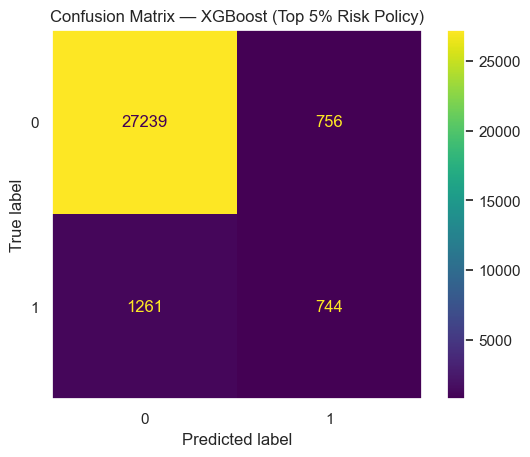

In [63]:
# Top 5% threshold
threshold_5pct = np.percentile(valid_pred, 95)
y_flag_5pct = (valid_pred >= threshold_5pct).astype(int)

cm_5pct = confusion_matrix(y_valid, y_flag_5pct)

ConfusionMatrixDisplay(cm_5pct).plot()
plt.grid(False)          # remove grid
plt.title("Confusion Matrix — XGBoost (Top 5% Risk Policy)")
plt.savefig(ARTIFACTS_DIR / "figures" / "cm_xgb_top5pct.png", dpi=150, bbox_inches="tight")

plt.show()


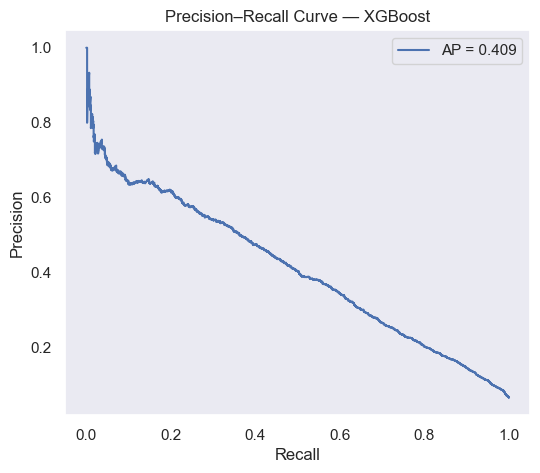

In [68]:
from sklearn.metrics import precision_recall_curve, average_precision_score

prec, rec, _ = precision_recall_curve(y_valid, valid_pred)
ap = average_precision_score(y_valid, valid_pred)

fig, ax = plt.subplots(figsize=(6,5))
ax.plot(rec, prec, label=f"AP = {ap:.3f}")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Precision–Recall Curve — XGBoost")
ax.legend()
ax.grid(False)

fig.savefig(ARTIFACTS_DIR / "figures" / "pr_curve_xgb.png", dpi=150, bbox_inches="tight")
plt.show()

In [60]:
valid_pred = xgb_final.predict_proba(X_valid_imp)[:, 1]

In [61]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from pathlib import Path

# project root path
PROJECT_ROOT = Path("..").resolve()   # if notebook is in notebooks/
FIGURES_DIR = PROJECT_ROOT / "artifacts" / "figures"
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# compute ROC
fpr, tpr, _ = roc_curve(y_valid, valid_pred)
roc_auc = auc(fpr, tpr)

# plot
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — XGBoost")
plt.legend()

# save
plt.savefig(FIGURES_DIR / "roc_curve_xgb.png", dpi=150, bbox_inches="tight")
plt.close()

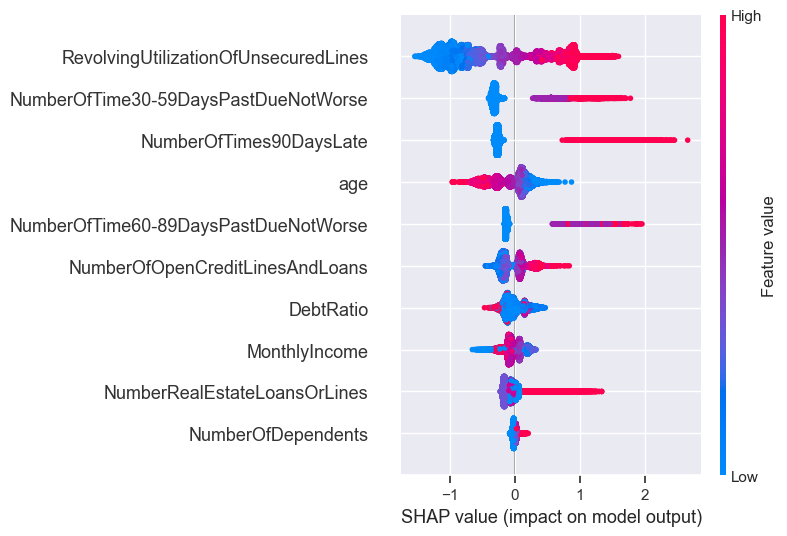

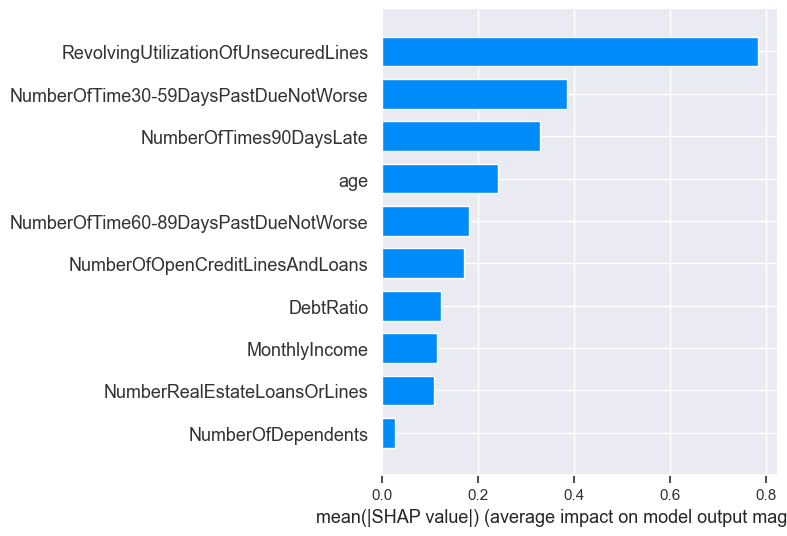

In [28]:
import shap

FIG_DIR = PROJECT_ROOT / "artifacts" / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

X_shap = pd.DataFrame(X_valid_imp, columns=X_train.columns)  # or X.columns

#X_shap = X_valid_imp.copy()

explainer = shap.TreeExplainer(xgb_final)
shap_values = explainer.shap_values(X_shap)

plt.rcParams["font.size"] = 11

plt.figure(figsize=(12, 6))
shap.summary_plot(shap_values, X_shap, show=False)
plt.tight_layout()
plt.savefig(FIG_DIR / "shap_summary_xgb.png", dpi=150, bbox_inches="tight")
plt.show()

plt.figure()
shap.summary_plot(shap_values, X_shap, plot_type="bar", show=False)
plt.tight_layout()
plt.savefig(FIG_DIR / "shap_bar_xgb.png", dpi=150, bbox_inches="tight")
plt.show()

In [58]:
joblib.dump(xgb_final, ARTIFACTS_DIR / "models" / "xgb_pipeline_best.joblib")

xgb_metrics.to_csv(ARTIFACTS_DIR / "metrics" / "topk_thresholds_xgb.csv", index=False)

<Figure size 640x480 with 0 Axes>